In [1]:
!pip install keras-tuner
from google.colab import drive
import pandas as pd
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import tensorflow as tf
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/rainfall_se_clean.csv')
df.head()
df.set_index('Date', inplace=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import time, numpy as np, tensorflow as tf
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self._epoch_start = None
        self.train_start = time.perf_counter()
    def on_epoch_begin(self, epoch, logs=None):
        self._epoch_start = time.perf_counter()
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.perf_counter() - self._epoch_start)
    def on_train_end(self, logs=None):
        self.total_train_time = time.perf_counter() - self.train_start
def measure_training_time(model, x_train, y_train, *, epochs=50, batch_size=128, val_split=0.1, callbacks=()):
    th = TimeHistory()
    hist = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=0,
        callbacks=[*callbacks, th],
    )
    return {
        "history": hist,
        "total_train_s": th.total_train_time,
        "mean_epoch_s": float(np.mean(th.epoch_times)),
        "median_epoch_s": float(np.median(th.epoch_times)),
    }
@tf.function
def _predict_graph(model, x):
    return model(x, training=False)
def measure_inference_time(model, x, *, batch_size=128, repeats=5, take_n=100):
    _ = model.predict(x[:batch_size], batch_size=batch_size, verbose=0)
    xs = x[:take_n]
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model.predict(xs, batch_size=batch_size, verbose=0)
        times.append(time.perf_counter() - t0)
    mean = float(np.mean(times))
    return {
        "per_100_samples_s": mean,
        "per_sample_ms": mean * 1000.0 / take_n,
    }

In [3]:
import tempfile, os, pathlib
def model_size_bytes(model):
    with tempfile.TemporaryDirectory() as d:
        path = pathlib.Path(d) / "tmp_model.keras"
        model.save(path, include_optimizer=False)
        return os.path.getsize(path)
def describe_model_complexity(model):
    params = model.count_params()
    return {
        "params": int(params)
    }

In [4]:
import numpy as np
rainfall_series = df[['Value_log']].values.astype('float32')
split = int(len(rainfall_series) * 0.8)
train_series = rainfall_series[:split]
test_series = rainfall_series[split:]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_series)
test_scaled = scaler.transform(test_series)
def create_sequences(data, sequence_len):
    a, b = [], []
    for i in range(len(data) - sequence_len):
        a.append(data[i:i+sequence_len])
        b.append(data[i+sequence_len])
    return np.array(a), np.array(b)
seq_len = 90
x_train, y_train = create_sequences(train_scaled, seq_len)
x_test, y_test = create_sequences(test_scaled, seq_len)
x_train = x_train.reshape(-1, seq_len, 1)
x_test = x_test.reshape(-1, seq_len, 1)

In [5]:
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_len, d_model):
        super().__init__()
        self.pos_encoding = self._positional_encoding(sequence_len, d_model)
    def _positional_encoding(self, position, d_model):
        pos = tf.range(position, dtype=tf.float32)[:, tf.newaxis]
        i   = tf.range(d_model,   dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1.0 / tf.pow(10000.0, (2*(i//2)) / tf.cast(d_model, tf.float32))
        angle_rads  = pos * angle_rates
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        return pos_encoding[tf.newaxis, ...]
    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

In [6]:
def encoder_block(x, d_model, ff_dim, heads, drop):
  attn = layers.MultiHeadAttention(num_heads=heads, key_dim=d_model)(x, x)
  x = layers.Add()([x, layers.Dropout(drop)(attn)])
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  f = layers.Dense(ff_dim, activation = 'relu')(x)
  f = layers.Dense(d_model)(f)
  x = layers.Add()([x, layers.Dropout(drop)(f)])
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  return x
def build_transformer(hp, sequence_len):
  d_model = hp.Int('d_model', min_value = 32, max_value = 128, step = 32 )
  blocks = hp.Int('blocks', min_value = 1, max_value = 3, step = 1)
  lr = hp.Float('lr', min_value = 1e-4, max_value = 5e-3, sampling = 'log')
  num_heads = hp.Int('num_heads', min_value = 2, max_value = 8, step = 1)
  ff_dim = hp.Int('ff_dim', min_value = 32, max_value = 128, step = 32)
  dropout_rate = hp.Float('dropout_rate', min_value = 0.0, max_value = 0.5, step = 0.1)
  inputs = layers.Input(shape=(sequence_len, 1))
  x = layers.Dense(d_model)(inputs)
  for _ in range(blocks):
    x = encoder_block(x, d_model, ff_dim, num_heads, dropout_rate)
  x = x[:, -1, :]
  output = layers.Dense(1)(x)
  model = models.Model(inputs = inputs, outputs = output)
  model.compile(loss = Huber(), optimizer = Adam(learning_rate=lr))
  return model

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
tunning = kt.RandomSearch(
    lambda hp: build_transformer(hp, seq_len),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir_Transformer',
    project_name='rainfall_Transformer'

)
tunning.search(x_train, y_train, validation_split=0.1, epochs=100, batch_size=64, shuffle = False, callbacks = [early_stopping, rlr])
best_model = tunning.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 00m 44s]
val_loss: 0.02025226131081581

Best val_loss So Far: 0.020160363987088203
Total elapsed time: 00h 25m 29s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
loss = best_model.evaluate(x_test, y_test)
print(f"Test Loss (MSE): {loss}")
best_hps = tunning.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0198
Test Loss (MSE): 0.01992684043943882
Best Hyperparameters: {'d_model': 64, 'blocks': 1, 'lr': 0.00012927768527617978, 'num_heads': 2, 'ff_dim': 128, 'dropout_rate': 0.1}


In [9]:
y_test_log = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = best_model.predict(x_test)
y_pred_log = scaler.inverse_transform(y_pred)

214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [11]:
best_hps = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_hps)
timing_train = measure_training_time(
    model, x_train, y_train,
    epochs=50,
    batch_size=128,
    val_split=0.1,
    callbacks=[early_stopping, rlr],
)
timing_infer = measure_inference_time(model, x_test, batch_size=128, repeats=5, take_n=100)
complexity = describe_model_complexity(model)
print("Training time (total s):", timing_train["total_train_s"])
print("Mean epoch time (s):", timing_train["mean_epoch_s"])
print("Inference per 100 samples (s):", timing_infer["per_100_samples_s"])
print("Per-sample inference (ms):", timing_infer["per_sample_ms"])
print("Params:", complexity["params"])

Training time (total s): 77.70682087199975
Mean epoch time (s): 1.9418719301250236
Inference per 100 samples (s): 1.1341651482000998
Per-sample inference (ms): 11.341651482000998
Params: 50241
Model size (MB): 0.65


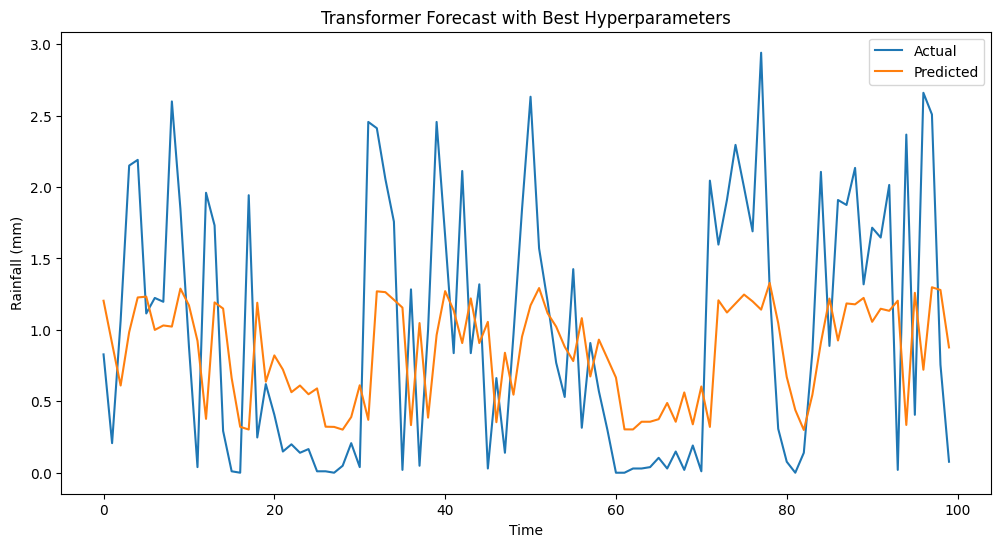

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot((y_test_log)[:100], label='Actual')
plt.plot((y_pred_log)[:100], label='Predicted')
plt.title("Transformer Forecast with Best Hyperparameters")
plt.xlabel("Time")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test_log, y_pred_log)
print(f"MAE: {mae:.4f} mm")
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
print(f"RMSE: {rmse:.4f} mm")
r2 = r2_score(y_test_log, y_pred_log)
print(f"R² Score: {r2:.4f}")

MAE: 0.5912 mm
RMSE: 0.7504 mm
R² Score: 0.1917


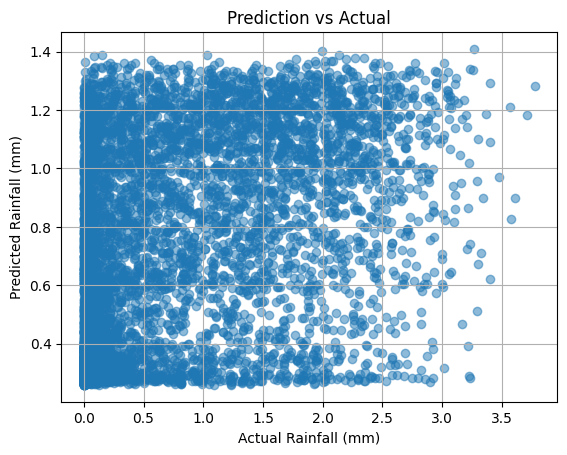

In [ ]:
plt.scatter(y_test_log, y_pred_log, alpha=0.5)
plt.xlabel("Actual Rainfall (mm)")
plt.ylabel("Predicted Rainfall (mm)")
plt.title("Prediction vs Actual")
plt.grid(True)
plt.show()